# Twitter Analysis
*Zhanwang Chen*

In this experiment, we try to explore the tweeter data and generate insights about:

1. the topics that users associate with Mercedes-Benz (general topics and Mercedes-Benz specific products)
2. things users like/hate about the brand and its products
3. the types of users, i.e., current customers of Mercedes-Benz who own a Mercedes product, prospective customers interested in buying a Mercedes and churners who have abandoned Mercedes-Benz or are about to.

Tweeter preprocessing includes stemming, tokenization.
Then Vadar rule-based sentiment analysis,
LDA topic model is used to find out the product that users like and dislike, along with Benz's product list
Pretrained language models such as Bert, XLM are used to classify different user types.

## 1. 
The topics that users associate with Mercedes-Benz (general topics and Mercedes-Benz specific products)

In [1]:
from collections import Counter
import nltk
import pandas as pd
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time

import matplotlib.pyplot as plt

plotly.offline.init_notebook_mode()

In [2]:
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    def initialize(self, csv_file, is_testing_set=False, from_cached=None):

        self.data = pd.read_csv(csv_file, error_bad_lines=False)
        #self.data=self.data.drop(columns=['SentimentSource', 'ItemID'])
        self.processed_data = self.data


In [3]:
data = TwitterData_Initialize()
data.initialize("mb.csv")

In [4]:
data.processed_data.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'location',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'profile_image_url'],
      dtype='object')

In [5]:
from langdetect import detect
lang=[]
for sent in data.processed_data["tweet"]:
    l=None
    try:
        l=detect(sent)
    except:
        l=None
    lang.append(l)

In [6]:
data.processed_data["lang"]=lang

In [7]:
sum([i=='en' for i in lang])

23799

In [8]:
sum([i=='en' for i in lang])/len(lang)

0.6456592512208356

In [9]:
sum([i=='de' for i in lang])/len(lang)

0.07805208898534997

In [10]:
n=sum([i==None for i in lang])/len(lang)
print("%.3f" %n )

0.000


In [11]:
#data.processed_data["tweet"].to_csv('/tmp/tweet.csv',index=False)

In [12]:
data.processed_data["SentimentText"] =data.processed_data["tweet"]

### Tokenization & stemming
For the text processing, ```nltk``` library is used. First, the tweets are tokenized using ```nlkt.word_tokenize``` and then, stemming is done using **PorterStemmer** as the tweets are 100% in english.


In [13]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               #self.remove_na,
                               self.remove_special_chars
                               #,
                               #self.remove_numbers
                              ]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "SentimentText"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["SentimentText"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "SentimentText"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [14]:
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            t = cleanup_method(t)
       

        self.processed_data = t

In [15]:
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data.head(5)

id      conversation_id     created_at        date  \
0  1133020126591311873  1133020126591311873  1558968023000  2019-05-27   
1  1133018830693904386  1133018830693904386  1558967714000  2019-05-27   
2  1133018706253156352  1133018706253156352  1558967684000  2019-05-27   
3  1133017519529299968  1133017519529299968  1558967401000  2019-05-27   
4  1133016373184143361  1133016373184143361  1558967128000  2019-05-27   

       time timezone     user_id       username                  name place  \
0  16:40:23     CEST  3075355580      mboftyler  Mercedes-BenzofTyler   NaN   
1  16:35:14     CEST  4209111569  guessthecaruk         Guess The Car   NaN   
2  16:34:44     CEST  3131276908  bramotorsport     Brasil Motorsport   NaN   
3  16:30:01     CEST  1553091258     hbc_online  HBC Vehicle Services   NaN   
4  16:25:28     CEST   476567053    suwatxjapan            ♥ JaPanese   NaN   

   ... location                                           hashtags cashtags  \
0  ...      NaN  ['#mercedesbenz', '#memorialdayweekend', '#mem...       []   
1  ...      NaN  ['#mbfanfoto', '#mercedesbenz', '#mercedes', '...       []   
2  ...      NaN  ['#e63', '#e63amg', '#63amg', '#mercedesamge63...       []   
3  ...      NaN  ['#unrecorded', '#mercedesbenza180', '#mercede...       []   
4  ...      NaN  ['#mercedesbenz', '#oh', '#o404', '#classic', ...       []   

                                                link  retweet  quote_url  \
0  https://twitter.com/mboftyler/status/113302012...      NaN        NaN   
1  https://twitter.com/guessthecaruk/status/11330...      NaN        NaN   
2  https://twitter.com/BraMotorsport/status/11330...      NaN        NaN   
3  https://twitter.com/HBC_Online/status/11330175...      NaN        NaN   
4  https://twitter.com/SuwatXjapan/status/1133016...      NaN        NaN   

   video                                  profile_image_url lang  \
0      0  https://pbs.twimg.com/profile_images/710565059...   en   
1      0  https://pbs.twimg.com/profile_images/112939044...   en   
2      0  https://pbs.twimg.com/profile_images/583849291...   es   
3      0  https://pbs.twimg.com/profile_images/519159853...   en   
4      0  https://pbs.twimg.com/profile_images/107723158...   en   

                                       SentimentText  
0  In celebration and remembrance of Americas fal...  
1  Posted • Der perfekte Beifahrer 🐶😍 📸 Dominik H...  
2  MercedesBenz  E63 AMG  E63 E63AMG 63AMG Merced...  
3  Take a look at this Unrecorded MercedesBenzA18...  
4      mercedesbenz OH O404 classic BusinThailand  …  

[5 rows x 27 columns]

In [16]:
class TwitterData_TokenStem():
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["SentimentText"] = list(map(lambda str: stemmer.stem(str.lower()), row["SentimentText"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            
            row["tokenized_text"] = [] + tokenizer(row["SentimentText"])
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)


In [17]:
data = TwitterData_TokenStem(data)
data.tokenize()


In [18]:
data.stem()
data.processed_data.head(5)

id      conversation_id     created_at        date  \
0  1133020126591311873  1133020126591311873  1558968023000  2019-05-27   
1  1133018830693904386  1133018830693904386  1558967714000  2019-05-27   
2  1133018706253156352  1133018706253156352  1558967684000  2019-05-27   
3  1133017519529299968  1133017519529299968  1558967401000  2019-05-27   
4  1133016373184143361  1133016373184143361  1558967128000  2019-05-27   

       time timezone     user_id       username                  name place  \
0  16:40:23     CEST  3075355580      mboftyler  Mercedes-BenzofTyler   NaN   
1  16:35:14     CEST  4209111569  guessthecaruk         Guess The Car   NaN   
2  16:34:44     CEST  3131276908  bramotorsport     Brasil Motorsport   NaN   
3  16:30:01     CEST  1553091258     hbc_online  HBC Vehicle Services   NaN   
4  16:25:28     CEST   476567053    suwatxjapan            ♥ JaPanese   NaN   

   ...                                           hashtags cashtags  \
0  ...  ['#mercedesbenz', '#memorialdayweekend', '#mem...       []   
1  ...  ['#mbfanfoto', '#mercedesbenz', '#mercedes', '...       []   
2  ...  ['#e63', '#e63amg', '#63amg', '#mercedesamge63...       []   
3  ...  ['#unrecorded', '#mercedesbenza180', '#mercede...       []   
4  ...  ['#mercedesbenz', '#oh', '#o404', '#classic', ...       []   

                                                link retweet  quote_url  \
0  https://twitter.com/mboftyler/status/113302012...     NaN        NaN   
1  https://twitter.com/guessthecaruk/status/11330...     NaN        NaN   
2  https://twitter.com/BraMotorsport/status/11330...     NaN        NaN   
3  https://twitter.com/HBC_Online/status/11330175...     NaN        NaN   
4  https://twitter.com/SuwatXjapan/status/1133016...     NaN        NaN   

   video                                  profile_image_url  lang  \
0      0  https://pbs.twimg.com/profile_images/710565059...    en   
1      0  https://pbs.twimg.com/profile_images/112939044...    en   
2      0  https://pbs.twimg.com/profile_images/583849291...    es   
3      0  https://pbs.twimg.com/profile_images/519159853...    en   
4      0  https://pbs.twimg.com/profile_images/107723158...    en   

                                       SentimentText  \
0  [i, n,  , c, e, l, e, b, r, a, t, i, o, n,  , ...   
1  [p, o, s, t, e, d,  , •,  , d, e, r,  , p, e, ...   
2  [m, e, r, c, e, d, e, s, b, e, n, z,  ,  , e, ...   
3  [t, a, k, e,  , a,  , l, o, o, k,  , a, t,  , ...   
4  [m, e, r, c, e, d, e, s, b, e, n, z,  , o, h, ...   

                                      tokenized_text  
0  [In, celebration, and, remembrance, of, Americ...  
1  [Posted, •, Der, perfekte, Beifahrer, 🐶😍, 📸, D...  
2  [MercedesBenz, E63, AMG, E63, E63AMG, 63AMG, M...  
3  [Take, a, look, at, this, Unrecorded, Mercedes...  
4  [mercedesbenz, OH, O404, classic, BusinThailan...  

[5 rows x 28 columns]

In [19]:
data.processed_data['stem_tokenized_text']=data.processed_data['tokenized_text'].map(lambda x: [x.lower() for x in x])

In [20]:
stemmer=nltk.PorterStemmer()

data.processed_data['stem_tokenized_text']=data.processed_data['tokenized_text'].map(lambda x: [stemmer.stem(xi) for xi in x])


In [22]:
len(data.processed_data)

36860

In [119]:
# with open("model_list.json", "w") as f:
#     json.dump(model_list, f)
with open("model_list.json", "r") as f:
    model_list = json.load(f)

In [24]:
from collections import Counter
model_count=Counter({e.lower():0 for e in model_list})

In [25]:
data.processed_data.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'location',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'profile_image_url', 'lang', 'SentimentText', 'tokenized_text',
       'stem_tokenized_text'],
      dtype='object')

In [ ]:
#data.processed_data.hashtags.map(lambda x: x.lower() )

{'mercedes', 'mot', 'repair', 'service'}

In [ ]:
#data.processed_data.hashtags

In [110]:
import json

hashtags_count=Counter()

for row in data.processed_data.hashtags:
    #print(row)
    row=row.replace("'",'"')
    for t in json.loads(row):
        hashtags_count[t.replace("#","")]+=1
hashtags_count.most_common()

In [111]:
hashtags_count.most_common()

[('mercedesbenz', 37327),
 ('mercedes', 7893),
 ('amg', 4937),
 ('3d', 2387),
 ('gclass', 2322),
 ('automotive', 2223),
 ('mercedesamg', 2215),
 ('benz', 2042),
 ('bmw', 2027),
 ('design', 1889),
 ('cars', 1707),
 ('mechanical', 1664),
 ('offroad', 1653),
 ('car', 1494),
 ('agriculture', 1401),
 ('audi', 1385),
 ('luxury', 1042),
 ('thebestornothing', 1015),
 ('porsche', 897),
 ('gwagon', 887),
 ('iron', 808),
 ('ny', 799),
 ('parts', 738),
 ('cclass', 694),
 ('engineering', 684),
 ('luxurycars', 663),
 ('eclass', 654),
 ('suv', 645),
 ('sls', 613),
 ('ford', 576),
 ('ferrari', 568),
 ('nyc', 530),
 ('volkswagen', 511),
 ('glc', 484),
 ('shöckl', 483),
 ('fashion', 483),
 ('tools', 473),
 ('sclass', 470),
 ('cla', 469),
 ('supercar', 461),
 ('gle', 455),
 ('brabus', 452),
 ('daimler', 448),
 ('supercars', 446),
 ('toyota', 446),
 ('carsofinstagram', 420),
 ('honda', 420),
 ('v8', 406),
 ('aclass', 403),
 ('auto', 402),
 ('classiccar', 397),
 ('suffolk', 394),
 ('classiccars', 393),
 ('

In [28]:
for row in data.processed_data.hashtags:
    for m in model_list:
        m_a=m.lower().strip().split(" ")
        if len(m)>2:
            if m_a[0] in row:
                model_count[m.lower()] +=1
        elif m_a in row:
                model_count[m.lower()] +=1
print(model_count.most_common())

[('sls amg', 676), ('g63 amg', 538), ('c63 amg', 462), ('sprinter', 344), ('g55 amg', 320), ('g550', 304), ('c43 amg', 258), ('c220', 229), ('s55 amg', 215), ('c300', 212), ('s63 amg', 200), ('e63 amg', 193), ('300sl', 190), ('g500', 177), ('e350', 160), ('e350 bluetec', 160), ('cls55 amg', 130), ('ml63 amg', 119), ('slr', 118), ('e400 hybrid', 116), ('c36 amg', 100), ('s550', 99), ('c250', 98), ('s600', 77), ('c230', 74), ('e300', 71), ('s500', 68), ('ml350', 66), ('ml350 bluetec', 66), ('s65 amg', 66), ('s350', 60), ('s350 bluetec', 60), ('600sel', 56), ('cls63 amg', 55), ('190e', 51), ('s400 hybrid', 41), ('sl500', 40), ('c240', 36), ('300d', 35), ('e500', 34), ('gl450', 34), ('sl55 amg', 32), ('e55 amg', 28), ('glk350', 28), ('e320', 27), ('e320 bluetec', 27), ('e320 cdi', 27), ('560sec', 26), ('500e', 25), ('sl65 amg', 24), ('s320', 21), ('sl63 amg', 21), ('ml320', 20), ('ml320 bluetec', 20), ('ml320 cdi', 20), ('300se', 20), ('c55 amg', 19), ('cls550', 18), ('sl550', 18), ('r350'

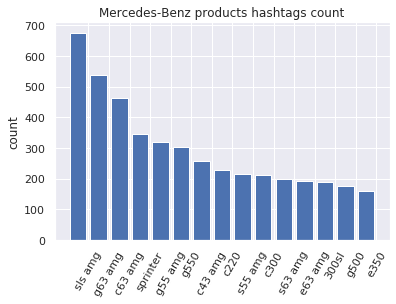

In [128]:
import seaborn as sns
sns.set()


labels, values = zip(*model_count.most_common(15))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values)
plt.xticks(indexes + width * 0.5, labels, rotation=60)
plt.ylabel("count")
plt.title("Mercedes-Benz products hashtags count")
plt.show()

In [130]:
#pd.DataFrame(dict(model_count.most_common(10)), index=[0])

sls amg  g63 amg  c63 amg  sprinter  g55 amg  g550  c43 amg  c220  s55 amg  \
0      676      538      462       344      320   304      258   229      215   

   c300  
0   212

In [131]:
hashtag_sub_model=hashtags_count.copy()
for k in model_count:
    del hashtag_sub_model[k]

In [132]:
hashtag_sub_model.most_common()

[('mercedesbenz', 37327),
 ('mercedes', 7893),
 ('amg', 4937),
 ('3d', 2387),
 ('gclass', 2322),
 ('automotive', 2223),
 ('mercedesamg', 2215),
 ('benz', 2042),
 ('bmw', 2027),
 ('design', 1889),
 ('cars', 1707),
 ('mechanical', 1664),
 ('offroad', 1653),
 ('car', 1494),
 ('agriculture', 1401),
 ('audi', 1385),
 ('luxury', 1042),
 ('thebestornothing', 1015),
 ('porsche', 897),
 ('gwagon', 887),
 ('iron', 808),
 ('ny', 799),
 ('parts', 738),
 ('cclass', 694),
 ('engineering', 684),
 ('luxurycars', 663),
 ('eclass', 654),
 ('suv', 645),
 ('sls', 613),
 ('ford', 576),
 ('ferrari', 568),
 ('nyc', 530),
 ('volkswagen', 511),
 ('glc', 484),
 ('shöckl', 483),
 ('fashion', 483),
 ('tools', 473),
 ('sclass', 470),
 ('cla', 469),
 ('supercar', 461),
 ('gle', 455),
 ('brabus', 452),
 ('daimler', 448),
 ('supercars', 446),
 ('toyota', 446),
 ('carsofinstagram', 420),
 ('honda', 420),
 ('v8', 406),
 ('aclass', 403),
 ('auto', 402),
 ('classiccar', 397),
 ('suffolk', 394),
 ('classiccars', 393),
 ('

## 2. 
Things users like/hate about the brand and its products


#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

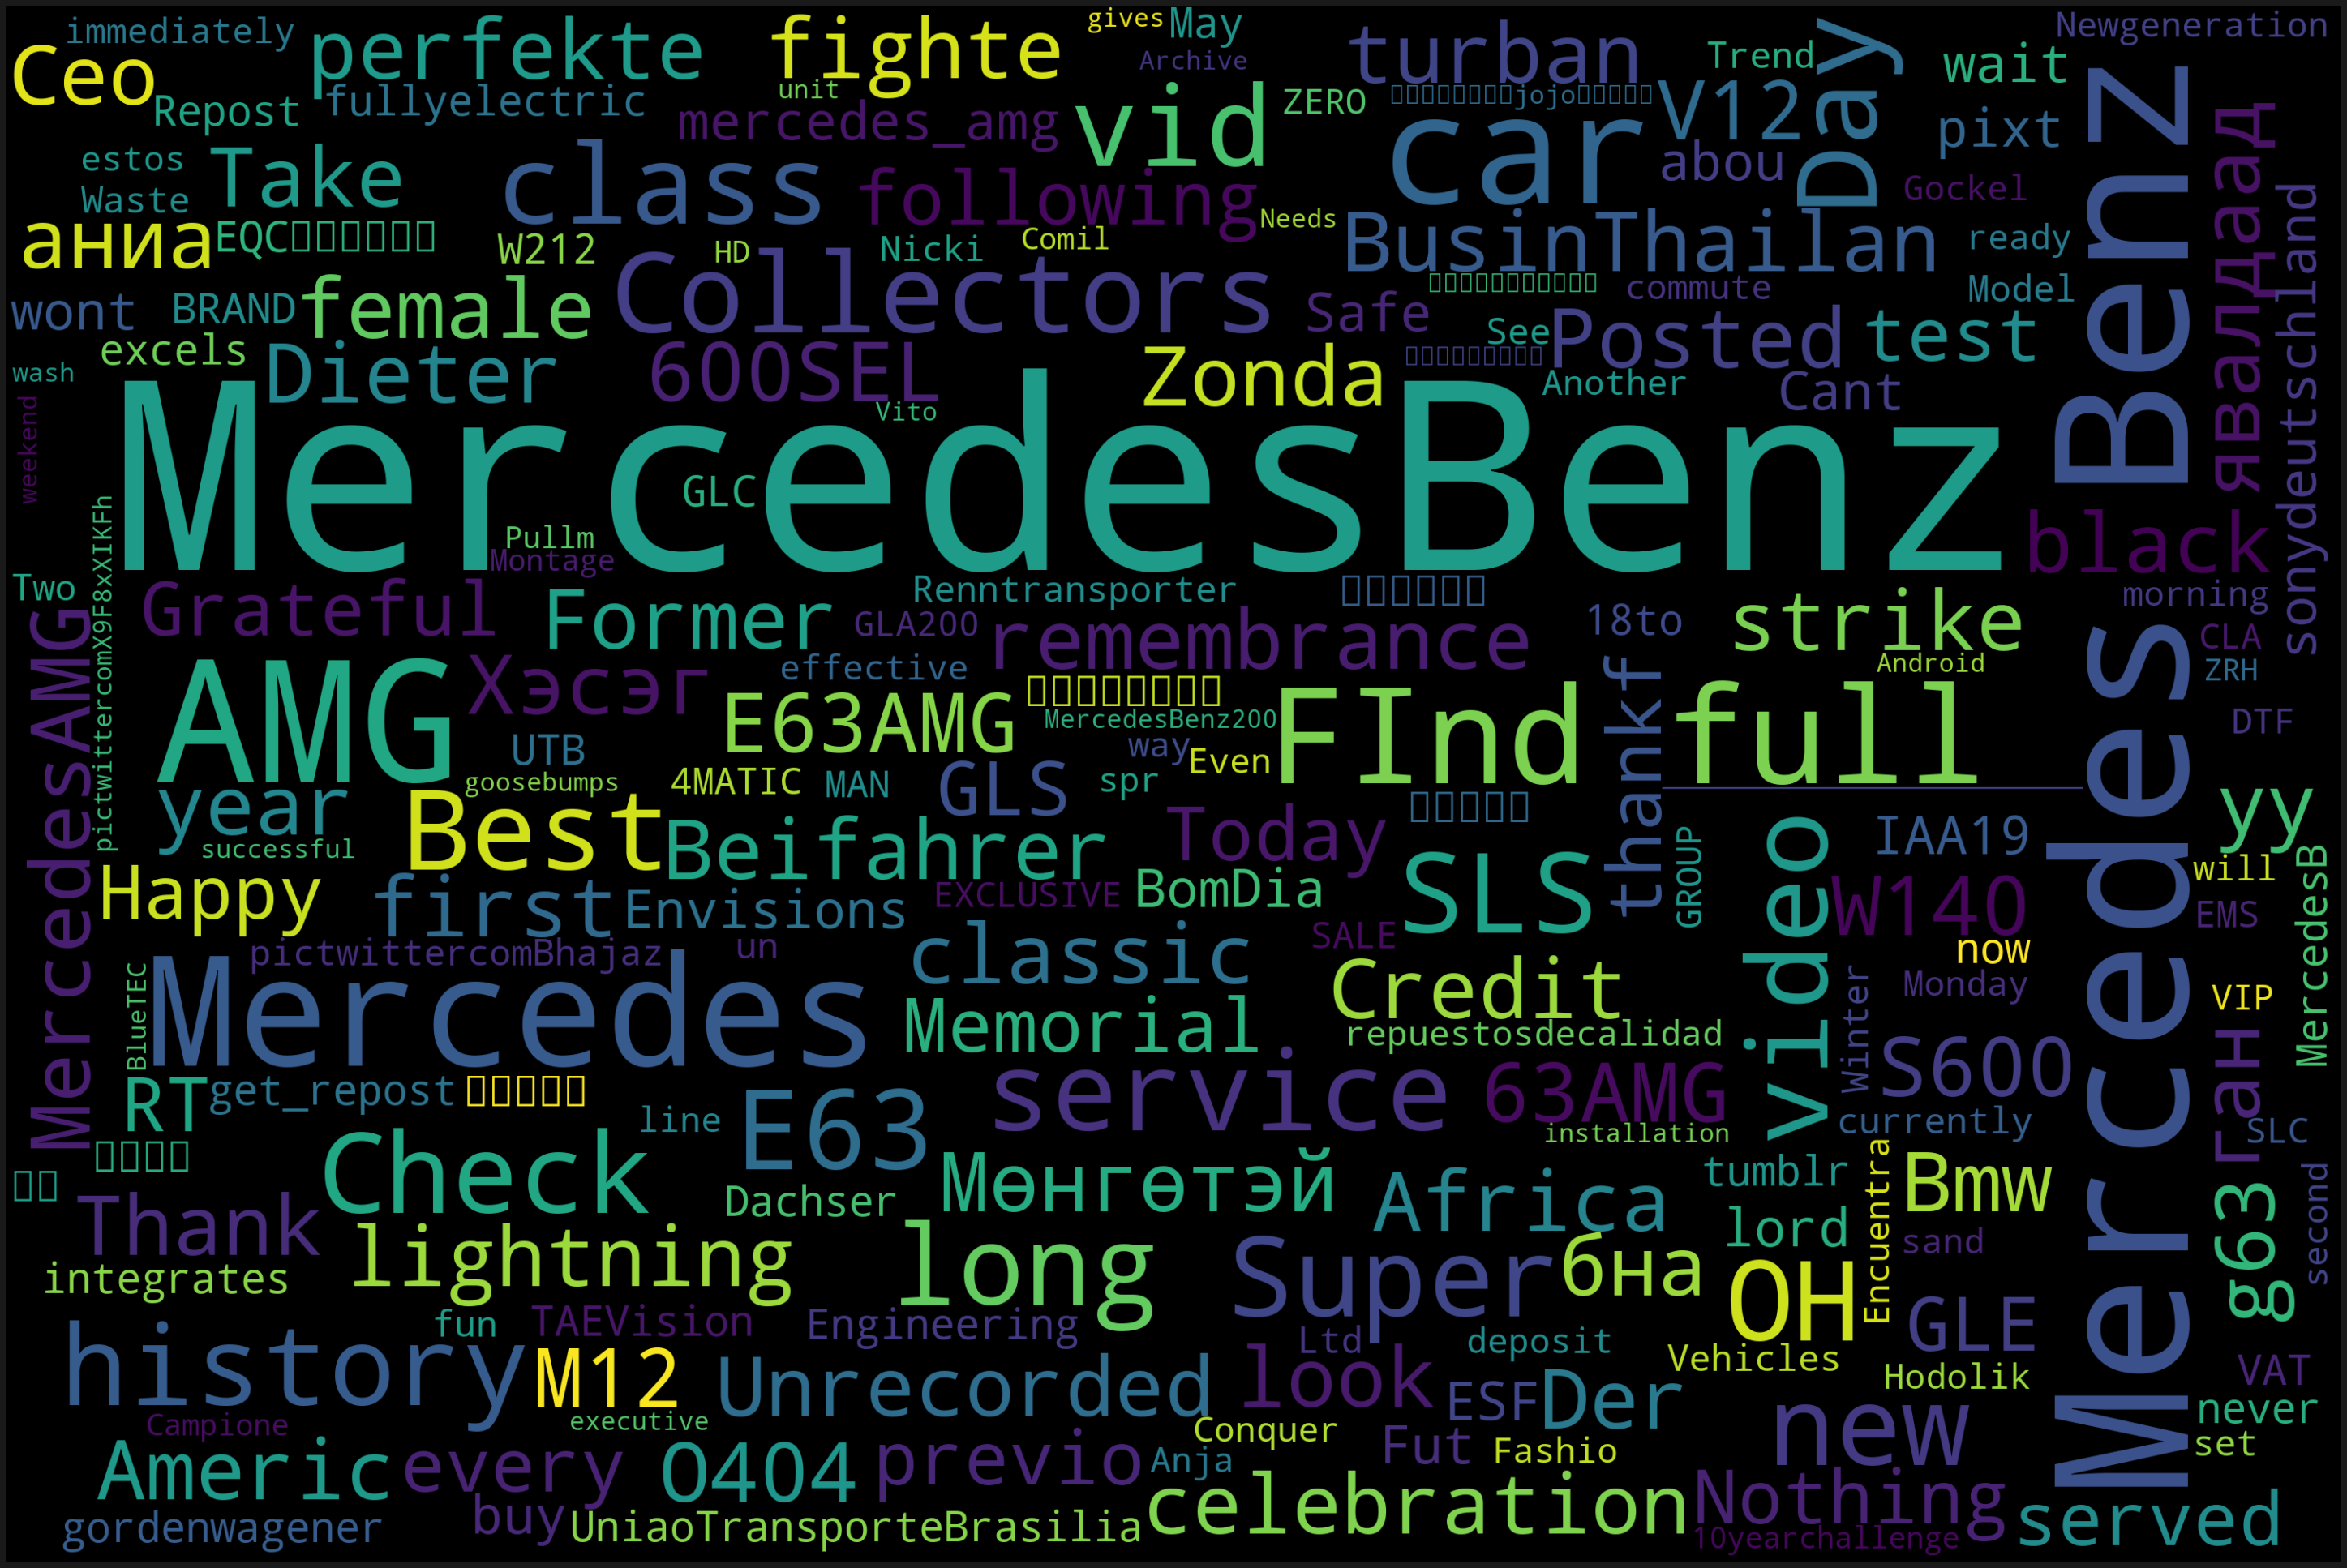

In [133]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = data.processed_data['tokenized_text']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

/home/zhanwang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.



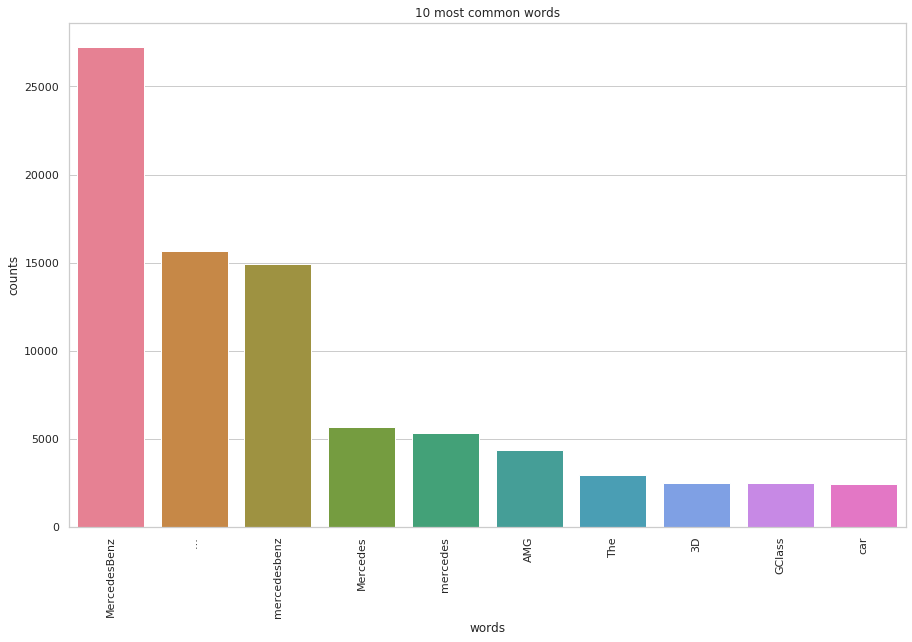

In [134]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_top_most_common_words(count_data, count_vectorizer,top=10):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:top]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english',lowercase=False,
      preprocessor=lambda x: x,
      # use our token dictionary
      tokenizer=lambda key: key)

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data.processed_data['tokenized_text'])

# Visualise the 10 most common words
plot_top_most_common_words(count_data, count_vectorizer,10)

In [136]:
#from vaderSentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
# for sentence in data.processed_data["tweet"][:12]:
#     vs = analyzer.polarity_scores(sentence)
#     data.processed_data.iloc[]
#     print("{:-<65} {}".format(sentence, str(vs)))
for i, sentence in data.processed_data.iterrows():
    vs = analyzer.polarity_scores(sentence["tweet"])
    
    data.processed_data.at[i,'neg'] = vs['neg']
    data.processed_data.at[i,'neu'] = vs['neu']
    data.processed_data.at[i,'pos'] = vs['pos']
    data.processed_data.at[i,'compound'] = vs['compound']

In [137]:
len(data.processed_data[data.processed_data['compound'] >= 0.05])

11343

In [ ]:
len(data.processed_data[data.processed_data['compound'] >= 0.05])/len(data.processed_data)

In [138]:
len(data.processed_data[data.processed_data['compound'] <= -0.05])

2242

In [139]:
a=data.processed_data['compound'] > -0.05
b=data.processed_data['compound'] < 0.05

In [140]:
len(data.processed_data[a & b])

23275

## positive tweets

/home/zhanwang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.



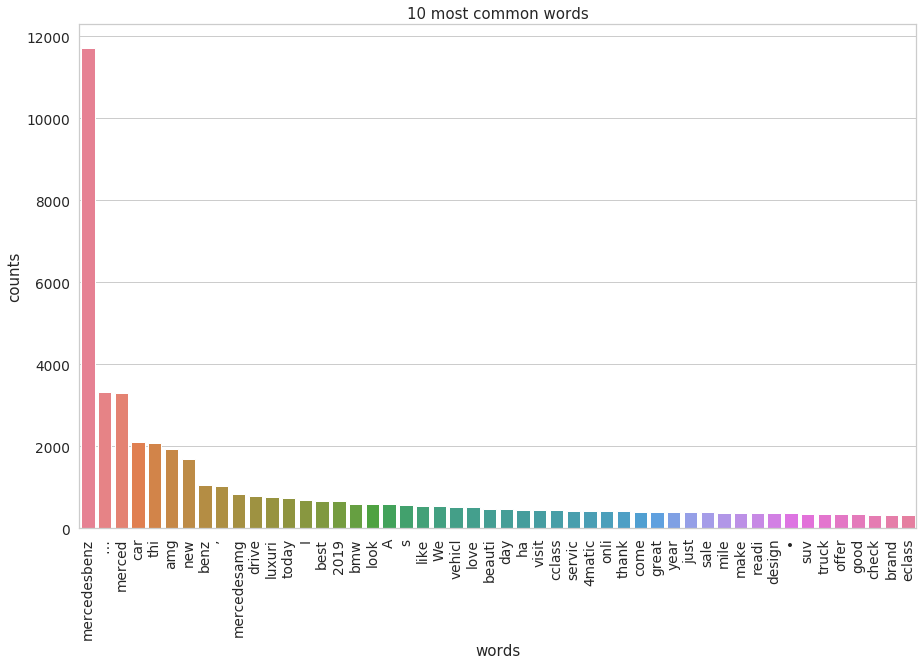

In [141]:
# Initialise the count vectorizer with the English stop words
en_stem_pos_vectorizer = CountVectorizer(stop_words="english", lowercase=False,
      preprocessor=lambda x: x,
      # use our token dictionary
      tokenizer=lambda key: key)


en_stem_pos_count_data = en_stem_pos_vectorizer.fit_transform(data.processed_data[(data.processed_data['compound'] >= 0.05) & 
                                                                                 (data.processed_data['lang']=='en')
                                                                                 ]['stem_tokenized_text'])

# Visualise the 10 most common words
plot_top_most_common_words(en_stem_pos_count_data, en_stem_pos_vectorizer,50)

In [143]:
import warnings
#warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, en_stem_pos_vectorizer, n_top_words):
    words = en_stem_pos_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 6
number_words = 13

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(en_stem_pos_count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, en_stem_pos_vectorizer, number_words)

Topics found via LDA:

Topic #0:
mercedesbenz … merced amg car new click pleas thi drive link truck visit

Topic #1:
mercedesbenz … merced car amg thi • mercedesamg new love luxuri best benz

Topic #2:
mercedesbenz … merced bmw car audi thi benz ’ ha brand tesla amg

Topic #3:
mercedesbenz merced new thi amg … car today drive mercedesamg 2019 servic look

Topic #4:
mercedesbenz ’ … merced s best gclass I benz new design thi amg

Topic #5:
mercedesbenz … merced thi benz mile 4matic car amg A luxuri 4dr I


In [144]:
#%%time
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./en_stem_pos_LDAvis_prepared'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    en_stem_pos_LDAvis_prepared = sklearn_lda.prepare(lda, en_stem_pos_count_data, en_stem_pos_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(en_stem_pos_LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath,"rb") as f:
    stem_pos_LDAvis_prepared = pickle.load(f)


/home/zhanwang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




NameError: name 'LDAvis_prepared' is not defined

In [145]:

pyLDAvis.save_html(stem_pos_LDAvis_prepared, './en_stem_pos_LDAvis_prepared'+ str(number_topics) +'.html')

stem_pos_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.035147 -0.015895       1        1  31.496672
5      0.045196 -0.039347       2        1  18.508633
1      0.008256 -0.020358       3        1  16.001131
4     -0.073437 -0.123681       4        1  13.316303
0      0.118714  0.079580       5        1  10.807432
2     -0.133874  0.119701       6        1   9.869829, topic_info=      Category          Freq          Term         Total  loglift  logprob
28114  Default    874.000000             ’    874.000000  30.0000  30.0000
4522   Default    503.000000           bmw    503.000000  29.0000  29.0000
23135  Default    489.000000             s    489.000000  28.0000  28.0000
9306   Default    253.000000        gclass    253.000000  27.0000  27.0000
28137  Default   2864.000000             …   2864.000000  26.0000  26.0000
28119  Default    308.000000             •    308.000000  25.0000  25.0000
13929  Default    333.000000          mile    333.000000  24.0000  24.0000
13292  Default  10188.000000  mercedesbenz  10188.000000  23.0000  23.0000
3501   Default    249.000000          audi    249.000000  22.0000  22.0000
6156   Default    194.000000         click    194.000000  21.0000  21.0000
4233   Default    581.000000          best    581.000000  20.0000  20.0000
2223   Default    601.000000             I    601.000000  19.0000  19.0000
5287   Default   1810.000000           car   1810.000000  18.0000  18.0000
1450   Default    363.000000        4matic    363.000000  17.0000  17.0000
7140   Default    316.000000        design    316.000000  16.0000  16.0000
1249   Default    136.000000            3D    136.000000  15.0000  15.0000
1447   Default    162.000000           4dr    162.000000  14.0000  14.0000
15052  Default    132.000000       offroad    132.000000  13.0000  13.0000
12156  Default    193.000000          link    193.000000  12.0000  12.0000
21789  Default    243.000000         pleas    243.000000  11.0000  11.0000
25063  Default    138.000000             t    138.000000  10.0000  10.0000
26673  Default    124.000000         volvo    124.000000   9.0000   9.0000
25283  Default    275.000000          test    275.000000   8.0000   8.0000
25074  Default     99.000000        taevis     99.000000   7.0000   7.0000
25894  Default    298.000000         truck    298.000000   6.0000   6.0000
12690  Default    100.000000           man    100.000000   5.0000   5.0000
13220  Default   2862.000000        merced   2862.000000   4.0000   4.0000
10867  Default    144.000000        inform    144.000000   3.0000   3.0000
13122  Default     99.000000        mechan     99.000000   2.0000   2.0000
27442  Default    111.000000           wow    111.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
22191   Topic6     39.789294           ps4     42.399992   2.2521  -6.1521
25274   Topic6     74.486610         tesla     81.654331   2.2238  -5.5251
3501    Topic6    165.762269          audi    249.217309   1.9079  -4.7251
4522    Topic6    269.638119           bmw    503.668986   1.6908  -4.2386
24159   Topic6     35.488345         solid     41.228028   2.1658  -6.2665
9237    Topic6     60.262619          game    100.165149   1.8076  -5.7370
15099   Topic6     34.251318   oldsaybrook     41.021771   2.1353  -6.3020
13292   Topic6    723.949752  mercedesbenz  10188.875294  -0.3286  -3.2510
28137   Topic6    342.041650             …   2864.578012   0.1904  -4.0007
13220   Topic6    292.863947        merced   2862.288582   0.0360  -4.1560
5287    Topic6    227.997582           car   1810.197003   0.2438  -4.4063
2401    Topic6     65.708459            To    174.791509   1.3373  -5.6505
4763    Topic6     78.045195         brand    281.127650   1.0342  -5.4784
9390    Topic6     49.835846       germani     98.607583   1.6333  -5.9269
10920   Topic6     47.422120        inspir     87.492626   1.7032  -5.9766


[('g63 amg', 170), ('c63 amg', 135), ('c43 amg', 123), ('sls amg', 119), ('c300', 105), ('sprinter', 84), ('s55 amg', 80), ('e63 amg', 77), ('c36 amg', 66), ('e350', 63), ('e350 bluetec', 63), ('g55 amg', 58), ('s63 amg', 56), ('g550', 56), ('300sl', 51), ('c230', 46), ('cls55 amg', 42), ('s550', 41), ('c220', 37), ('slr', 35), ('e300', 34), ('s500', 33), ('g500', 29), ('s600', 22), ('c240', 21), ('gl450', 18), ('600sel', 17), ('ml350', 16), ('ml350 bluetec', 16), ('s400 hybrid', 16), ('190e', 16), ('s350', 16), ('s350 bluetec', 16), ('c250', 16), ('cls63 amg', 14), ('s65 amg', 12), ('sl500', 12), ('300d', 12), ('ml63 amg', 11), ('e400 hybrid', 10), ('sl63 amg', 9), ('e500', 9), ('e55 amg', 9), ('sl55 amg', 9), ('glk350', 8), ('300se', 7), ('e320', 6), ('e320 bluetec', 6), ('e320 cdi', 6), ('c55 amg', 6), ('e550', 5), ('c350', 5), ('300sel', 5), ('clk350', 4), ('300sd', 4), ('sl65 amg', 4), ('sl550', 4), ('gl550', 3), ('gl350 bluetec', 3), ('500e', 3), ('clk55 amg', 3), ('280ce', 3), (

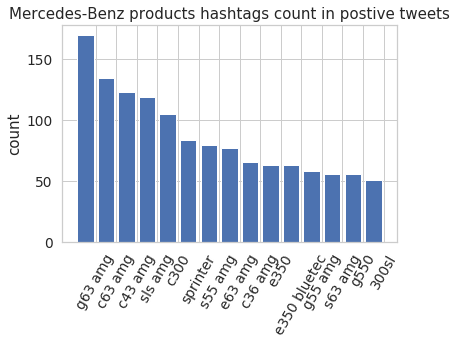

In [171]:
import json

pos_hashtags_count=Counter()
pos_model_count=Counter()
for row in data.processed_data[(data.processed_data['compound'] >= 0.05)].hashtags:
    #print(row)
    row=row.replace("'",'"')
    for t in json.loads(row):
        pos_hashtags_count[t.replace("#","")]+=1

for row in data.processed_data[(data.processed_data['compound'] >= 0.05)].hashtags:
    for m in model_list:
        m_a=m.lower().strip().split(" ")
        if len(m)>2:
            if m_a[0] in row:
                pos_model_count[m.lower()] +=1
        elif m_a in row:
                pos_model_count[m.lower()] +=1
print(pos_model_count.most_common())
labels, values = zip(*pos_model_count.most_common(15))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values)
plt.xticks(indexes + width * 0.5, labels, rotation=60)
plt.ylabel("count")
plt.title("Mercedes-Benz products hashtags count in postive tweets")
plt.show()

## Negative tweets

/home/zhanwang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.

/home/zhanwang/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 128249 missing from current font.

/home/zhanwang/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning:

Glyph 128249 missing from current font.



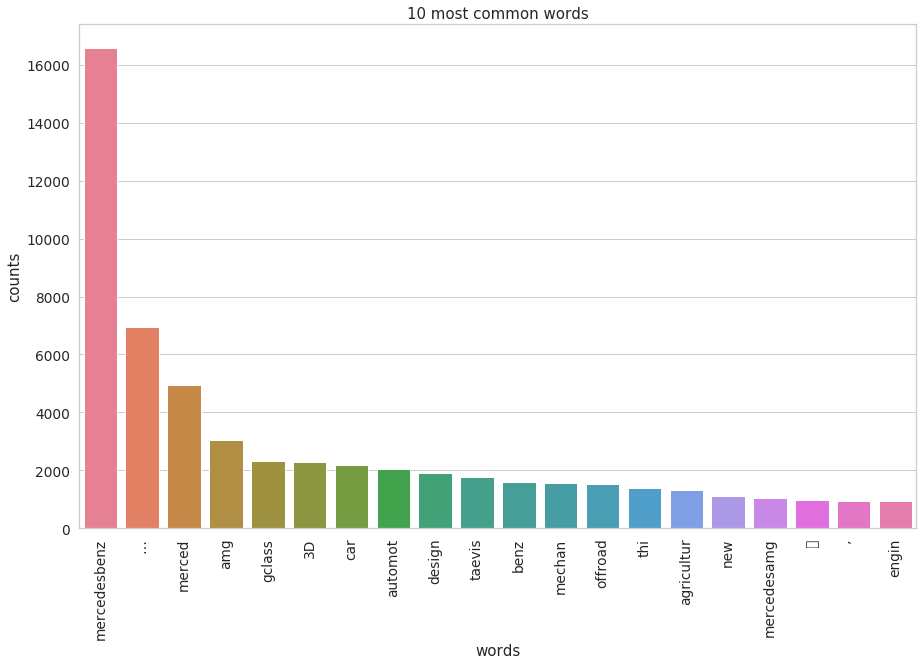

In [166]:
# Initialise the count vectorizer with the English stop words
en_stem_neg_vectorizer = CountVectorizer(stop_words="english", lowercase=False,
      preprocessor=lambda x: x,
      # use our token dictionary
      tokenizer=lambda key: key)


en_stem_neg_count_data = en_stem_neg_vectorizer.fit_transform(data.processed_data[(data.processed_data['compound'] <= 0.05) & 
                                                                                 (data.processed_data['lang']=='en')
                                                                                 ]['stem_tokenized_text'])
# Visualise the 10 most common words
plot_top_most_common_words(en_stem_neg_count_data, en_stem_neg_vectorizer,20)

In [167]:
import warnings
#warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = stem_pos_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 6
number_words = 13

# Create and fit the LDA model
en_stem_neg = LDA(n_components=number_topics)
en_stem_neg.fit(en_stem_neg_count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(en_stem_neg, en_stem_neg_vectorizer, number_words)

Topics found via LDA:

Topic #0:
mercedeseqc mercedesbenzslr arctic نانو_سيراميك blockchain champagnedatefriday mercedesccoup corsair cartrack mantém oldbutgold corral thebossautogroup

Topic #1:
mercedeseqc نانو_سيراميك mercedesbenzslr abudhabimotor لمزيد thrive complac champagnedatefriday blockchain corgi w205amg exhibición deviateautosport

Topic #2:
mercedeseqc نانو_سيراميك mercedesbenzslr champagnedatefriday لمزيد arctic blockchain s63amg btcc oldbutgold superturbodiesel axelsautomot mercedesccoup

Topic #3:
mercedeseqc glogal 49780 نانو_سيراميك barco dreamy😃💫 tal mercedesbenzeqc peculiar amglov 📍silver arctic jualmobilmurah

Topic #4:
mercedeseqc نانو_سيراميك thrive multibeam 61150 mercedesbenzslr cobrar ماينقصها 60mph element erstmalig oldbutgold testdriven

Topic #5:
mercedeseqc نانو_سيراميك champagnedatefriday mercedesbenzslr btcc oldbutgold potenza axelsautomot hermosabeach thrive teslaroadst 23td vito


In [168]:
%%time
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./stem_pos_ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    stem_neg_LDAvis_prepared = sklearn_lda.prepare(en_stem_neg, en_stem_neg_count_data, en_stem_neg_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(stem_neg_LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath,"rb") as f:
    stem_neg_LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(stem_neg_LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

stem_neg_LDAvis_prepared

/home/zhanwang/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




CPU times: user 23.6 s, sys: 130 ms, total: 23.7 s
Wall time: 11min 4s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.080567 -0.159380       1        1  22.165978
3      0.349508 -0.010297       2        1  21.166045
0     -0.078428 -0.055447       3        1  18.813942
2     -0.076937  0.036964       4        1  14.983435
5     -0.054713  0.079313       5        1  13.370683
1     -0.058864  0.108848       6        1   9.499918, topic_info=      Category         Freq                Term         Total  loglift  \
12112  Default  2065.000000              gclass   2065.000000  30.0000   
1721   Default  2043.000000                  3D   2043.000000  29.0000   
30829  Default  1581.000000              taevis   1581.000000  28.0000   
9332   Default  1696.000000              design   1696.000000  27.0000   
4838   Default  1834.000000             automot   1834.000000  26.0000   
16915  Default  1394.000000              mechan   1394.000000  25.0000   
19680  Default  1361.000000             offroad   1361.000000  24.0000   
3699   Default  1173.000000          agricultur   1173.000000  23.0000   
35941  Default   856.000000                   📹    856.000000  22.0000   
4030   Default  2701.000000                 amg   2701.000000  21.0000   
14338  Default   751.000000                iron    751.000000  20.0000   
17047  Default  4302.000000              merced   4302.000000  19.0000   
34843  Default   660.000000                   ▸    660.000000  18.0000   
3124   Default   660.000000                  NY    660.000000  17.0000   
7050   Default  1889.000000                 car   1889.000000  16.0000   
18069  Default   652.000000                mile    652.000000  15.0000   
12932  Default   625.000000              gwagon    625.000000  14.0000   
11079  Default   517.000000                farm    517.000000  13.0000   
35907  Default   505.000000                   📰    505.000000  12.0000   
5506   Default  1386.000000                benz   1386.000000  11.0000   
27087  Default   446.000000             project    446.000000  10.0000   
31338  Default  1195.000000                 thi   1195.000000   9.0000   
1985   Default   685.000000              4matic    685.000000   8.0000   
31599  Default   408.000000                tool    408.000000   7.0000   
19559  Default   405.000000                 nyc    405.000000   6.0000   
5996   Default   688.000000                 bmw    688.000000   5.0000   
29274  Default   397.000000              shöckl    397.000000   4.0000   
17118  Default   918.000000         mercedesamg    918.000000   3.0000   
29456  Default   492.000000                  sl    492.000000   2.0000   
1980   Default   375.000000                 4dr    375.000000   1.0000   
...        ...          ...                 ...           ...      ...   
7647    Topic6    39.533840             certifi     48.677894   2.1458   
3032    Topic6   205.725248                   I    367.413161   1.7739   
8568    Topic6    53.459705             control     80.034794   1.9504   
6770    Topic6    34.574517                c230     44.917574   2.0922   
4596    Topic6    54.682117             atlanta     88.904121   1.8679   
17128   Topic6    47.058396       mercedesamgf1     73.073814   1.9138   
17498   Topic6    57.560716       mercedesbenz…    107.636352   1.7280   
17156   Topic6  1055.409830        mercedesbenz  14421.773081  -0.2609   
17238   Topic6    54.407124  mercedesbenzcanada    104.317950   1.7029   
17047   Topic6   466.447537              merced   4302.052001   0.1322   
34760   Topic6   548.874029                   …   6056.011461  -0.0471   
8920    Topic6    66.573289              custom    151.760603   1.5299   
17410   Topic6    49.816447       mercedesbenzp     94.080918   1.7181   
34735   Topic6   141.513156                   ’    821.563901   0.5951   
7760    Topic6   107.120211               check    529.834149   0.7553   
2992    Topic6    47.973364                  F1

In [158]:
import warnings
#warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 6
number_words = 13

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
MercedesBenz en la … el y que Mercedes del para los AMG tu

Topic #1:
MercedesBenz … 4MATIC miles CClass mercedesbenz AMG 4dr drive Mercedes EClass test 2019

Topic #2:
MercedesBenz … 3D GClass TAEVision Automotive The Design AMG Agriculture Mechanical Mercedes OffRoad

Topic #3:
mercedesbenz MercedesBenz MERCEDESBENZ € … CDI A ’ IVA esposta 180 new bmw

Topic #4:
MercedesBenz … mercedesbenz Mercedes mercedes und der die em amg e Benz benz

Topic #5:
mercedesbenz … mercedes MercedesBenz amg Mercedes car cars AMG benz mercedesamg Benz •


In [159]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
hdp = HdpModel(common_corpus, common_dictionary)

/home/zhanwang/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.

/home/zhanwang/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [ ]:
%%time
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

In [161]:
LDAvis_prepared

NameError: name 'LDAvis_prepared' is not defined

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text
#stop_words='english',
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,  lowercase=False)    


x = tfidf.fit_transform(data.processed_data["SentimentText"])

[('sls amg', 557), ('g63 amg', 368), ('c63 amg', 327), ('g55 amg', 262), ('sprinter', 260), ('g550', 248), ('c220', 192), ('g500', 148), ('s63 amg', 144), ('300sl', 139), ('c43 amg', 135), ('s55 amg', 135), ('e63 amg', 116), ('ml63 amg', 108), ('c300', 107), ('e400 hybrid', 106), ('e350', 97), ('e350 bluetec', 97), ('cls55 amg', 88), ('slr', 83), ('c250', 82), ('s550', 58), ('s600', 55), ('s65 amg', 54), ('ml350', 50), ('ml350 bluetec', 50), ('s350', 44), ('s350 bluetec', 44), ('cls63 amg', 41), ('600sel', 39), ('e300', 37), ('190e', 35), ('s500', 35), ('c36 amg', 34), ('c230', 28), ('sl500', 28), ('s400 hybrid', 25), ('e500', 25), ('560sec', 24), ('sl55 amg', 23), ('300d', 23), ('500e', 22), ('e320', 21), ('e320 bluetec', 21), ('e320 cdi', 21), ('s320', 21), ('sl65 amg', 20), ('glk350', 20), ('e55 amg', 19), ('ml320', 19), ('ml320 bluetec', 19), ('ml320 cdi', 19), ('gl450', 16), ('c240', 15), ('cls550', 15), ('r350', 15), ('r350 bluetec', 15), ('sl550', 14), ('c55 amg', 13), ('300se',

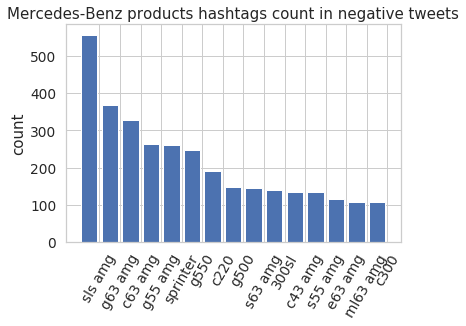

In [172]:
import json

neg_hashtags_count=Counter()
neg_model_count=Counter()
for row in data.processed_data[(data.processed_data['compound'] <= 0.05)].hashtags:
    #print(row)
    row=row.replace("'",'"')
    for t in json.loads(row):
        neg_hashtags_count[t.replace("#","")]+=1

for row in data.processed_data[(data.processed_data['compound'] <= 0.05)].hashtags:
    for m in model_list:
        m_a=m.lower().strip().split(" ")
        if len(m)>2:
            if m_a[0] in row:
                neg_model_count[m.lower()] +=1
        elif m_a in row:
                neg_model_count[m.lower()] +=1
print(neg_model_count.most_common())
labels, values = zip(*neg_model_count.most_common(15))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values)
plt.xticks(indexes + width * 0.5, labels, rotation=60)
plt.ylabel("count")
plt.title("Mercedes-Benz products hashtags count in negative tweets")
plt.show()

## 3. 
The types of users, i.e. current customers of Mercedes-Benz who own a Mercedes product, prospective customers interested in buying a Mercedes and churners who have abandoned Mercedes-Benz or are about to

1 : current customers of Mercedes-Benz who own a Mercedes product
2 : prospective customers interested in buying a Mercedes
3 : churners who have abandoned Mercedes-Benz or are about to

In [173]:
data.processed_data["user_type"]=0

In [180]:
import pickle
with open("data.processed_data.pkl","wb") as f:
    pickle.dump(data.processed_data,f)

In [176]:
data.processed_data[["tweet","user_type"]].to_csv("/tmp/train_tweets.csv", index=False)

Still need to sell our house.  http://tour.realtysouth.com/tour/titan/?id=4990274&reg=true&_seoAddress=2461-MOUNTAIN-VISTA-DR-VESTAVIA-HILLS-AL-814391┬áÔÇĞ Do you work at #MercedesBenz #GrandviewHospital ? Easy drive to work - no city traffic. Good schools, big lot and great for toddlers, tweens and teens.